# Correlogram along trial moments

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
#from fitting_functions import cross_validate_model
#from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import timeseries_PSTH

one = ONE()

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmpmacezr0n/cache.zip Bytes: 114344818


100%|██████████| 109.04771614074707/109.04771614074707 [00:52<00:00,  2.07it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [3]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [17]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

use_data['time'] = design_matrix['Bin']

In [ ]:
# Start a matrix with #trials x # wheel bins
time_step = np.median(np.diff(time))
interval_length = int((t_end+t_init)/time_step + .25 * 
                        (t_end+t_init)/time_step) # This serves as an estimation for size of data
series_stack = np.zeros((len(onset_times), interval_length)) * np.nan


In [18]:
use_data

,avg_wheel_vel,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Lick count,time
0,0.040864,0.008135,-0.233432,-0.150326,-0.150832,0.445143,0.267789,0.044518,0.393392,-0.683561,-0.073089,929.0
1,0.060396,-0.027710,-0.323080,-0.047746,-0.118164,0.553001,0.335435,-0.342506,0.473742,-0.328128,-0.076045,930.0
2,0.051345,-0.132856,-0.256422,-0.159178,0.014572,0.452773,0.278356,0.020299,0.360299,-0.685770,-0.074080,931.0
3,0.118243,-0.217515,0.276170,-0.091319,0.150669,0.387632,0.237923,0.108488,0.308001,-0.716502,-0.069378,932.0
4,0.353650,-0.251437,0.335073,0.175852,0.312642,0.218313,0.122358,-0.039340,0.295119,-0.644155,-0.065084,933.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33735,0.057510,-0.087648,-0.472501,-0.381054,-0.224580,-0.052357,-0.219147,-0.581375,-0.335891,0.243304,-0.097070,35722.0
33736,0.058573,-0.076131,-0.460000,-0.451729,-0.231396,-0.051966,-0.223216,-0.539091,-0.364137,0.190127,-0.097080,35723.0
33737,0.057048,-0.072002,-0.463179,-0.410579,-0.225592,-0.050409,-0.217426,-0.580009,-0.374618,0.147688,-0.096768,35724.0
33738,0.057497,-0.072424,-0.453680,-0.404082,-0.227286,-0.051385,-0.219165,-0.559096,-0.398946,0.197318,-0.096770,35725.0


In [60]:
# subtract_baseline can be True, False, or pupil
event = 'stimOn_times'
var = 'avg_wheel_vel'

#time = use_data['time']
#position = use_data['whisker_me']
trials = session_trials.copy()
t_init = 5  # bins
t_end = 20 # bins
#subtract_baseline = False

#series_df = pd.DataFrame({'time':time, 'position':position})
onset_times = trials[event]
binned_event_times = onset_times * 10
binned_event_times = binned_event_times.astype(int)

stacked_trials = []
time = np.arange(-0.5, 2, 0.1)
for e, event in enumerate(binned_event_times[1:-1]):
    trial_snippet = np.array(use_data.loc[(use_data['time'] >= event - t_init) & (use_data['time'] <= event + t_end), var])
    
    if len(trial_snippet) > 24:
        trial_snippet = trial_snippet[:24]
    if len(trial_snippet) == 24:
        if e == 0:
            stacked_trials = trial_snippet
        else:
            stacked_trials = np.vstack((stacked_trials, trial_snippet))
        



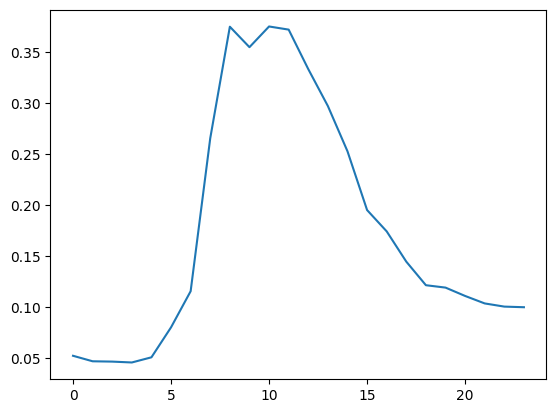

In [65]:
plt.plot(np.mean(stacked_trials, axis=0))

In [54]:
event - t_init

2176

In [52]:
use_data.loc[(use_data['time'] >= event - t_init) & (use_data['time'] <= event + t_end)]

,avg_wheel_vel,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Lick count,time
1241,0.425934,-0.022543,0.363586,0.192261,0.510835,0.192271,0.085845,0.367333,0.452037,-0.014170,-0.055925,2183.0
1242,0.669731,0.022731,0.264884,0.290306,0.560059,-0.121008,-0.039242,0.026547,0.146831,0.206597,-0.050145,2184.0
1243,0.560010,0.019017,0.395731,0.437393,0.432710,-0.120347,-0.026988,0.120089,0.288101,0.189709,-0.048535,2185.0
1244,0.759982,-0.016810,0.260829,0.216874,0.429910,0.042366,0.059244,0.207796,0.026503,0.264200,-0.047374,2186.0
1245,0.749061,-0.025487,0.200986,-0.094085,0.580581,-0.109008,0.011147,0.180558,-0.013444,0.077015,-0.041728,2187.0
1246,0.696031,0.005625,0.279032,-0.102415,0.569144,-0.007924,-0.284469,0.117029,-0.031853,-0.079125,-0.039735,2188.0
1247,0.832343,0.082484,0.321791,-0.089607,0.343562,-0.122073,-0.103422,0.204186,-0.040260,0.006028,-0.045338,2189.0
1248,0.614641,0.235861,0.415185,-0.017542,-0.007691,0.022258,-0.401983,0.415026,0.081870,0.222733,-0.054147,2190.0
1249,0.116283,0.406632,0.470464,0.084499,0.089769,-0.165089,-0.359832,0.437589,0.200388,0.438275,-0.060324,2191.0
1250,0.000251,0.411874,0.530043,0.149651,-0.029246,-0.245280,-0.374763,0.171234,0.180890,0.509749,-0.063988,2192.0


In [48]:
trial_snippet

27

In [50]:
np.shape(trial_snippet)

(19,)

In [36]:
np.shape(stacked_trials)

(24,)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


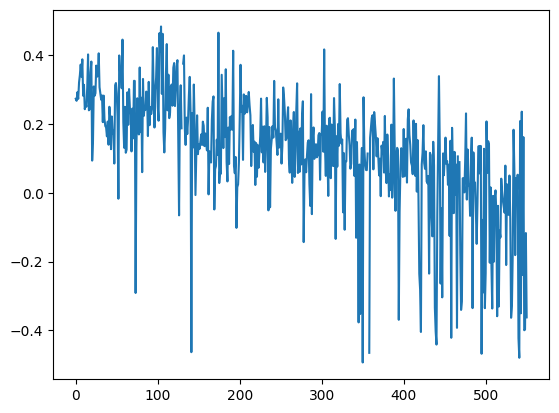

In [32]:
plt.plot(np.nanmean(series_stack, axis=1))

In [31]:
    # subtract_baseline can be True, False, or pupil
    event = 'stimOn_times'
    time = use_data['time']
    position = use_data['whisker_me']
    trials = session_trials.copy()
    t_init = 0.5
    t_end = 2
    subtract_baseline = False
    
    series_df = pd.DataFrame({'time':time, 'position':position})
    onset_times = trials[event]

    # Start a matrix with #trials x # wheel bins
    time_step = np.median(np.diff(time))
    interval_length = int((t_end+t_init)/time_step + .25 * 
                          (t_end+t_init)/time_step) # This serves as an estimation for size of data
    series_stack = np.zeros((len(onset_times), interval_length)) * np.nan

    # Loop through trials
    for t, trial_onset in enumerate(onset_times):
        
        if t < len(onset_times)-1:
            # Get next trial
            next_onset = onset_times[t+1]
        else:
            next_onset = trial_onset + t_end + 1
        
        if (np.isnan(trial_onset) == False) & (np.isnan(next_onset) == False):
            if len(series_df.loc[series_df['time'] > trial_onset, 'time']) > 0:
                
                trial_onset_index = series_df.loc[series_df['time'] > trial_onset, 
                                                    'time'].reset_index()['index'][0]
                next_onset_index = series_df.loc[series_df['time'] > next_onset, 
                                                    'time'].reset_index()['index'][0]
                onset_time = series_df['time'][trial_onset_index]
                next_onset_time = series_df['time'][next_onset_index]
                
                # Get time from first trial (only once to avoid the last trial)
                if t == 0:
                    
                    time_window = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                                (series_df['time'] <= trial_onset+t_end), 'time'] - onset_time
                
                # Subtract baseline if requested
                if subtract_baseline == True:
                    onset_position = series_df['position'][trial_onset_index]
                    # Populate dataframe with useful trial-aligned information
                    window_values = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                                (series_df['time'] <= trial_onset+t_end), 
                                                'position'] - onset_position 
                elif subtract_baseline == False:
                    window_values = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                                  (series_df['time'] <= trial_onset+t_end), 'position']
                    
                elif subtract_baseline == 'pupil':
                    max_pupil = np.max(series_df['position'])
                    min_pupil = np.min(series_df['position'])
                    series_df['norm_position'] = (series_df['position']) * 100 / (max_pupil - min_pupil)  #  (series_df['position'] - min_pupil) * 100 / (max_pupil - min_pupil)
                    baseline = np.mean(series_df.loc[(series_df['time'] > trial_onset-t_init) & 
                                                     (series_df['time'] < trial_onset), 'norm_position'])
                    window_values = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                                (series_df['time'] <= trial_onset+t_end), 
                                                'norm_position'] - baseline 

                # Trim values of next trial
                window_values = np.array(window_values)
                time_window = np.array(time_window)
                window_values[np.where(time_window > (next_onset_time - trial_onset))] = np.nan
                series_stack[t, :len(window_values)] = window_values
                        
    # Build data frame with extra info
    preprocessed_trials = prepro(trials)
    df_stack = pd.DataFrame(series_stack[:, :len(window_values)])
    df_stack['feedback'] = preprocessed_trials['feedbackType']
    df_stack['choice'] = preprocessed_trials['choice']
    df_stack['contrast'] = preprocessed_trials['contrast']
    df_stack['response_time'] = preprocessed_trials['response_times'] - preprocessed_trials['stimOn_times']
    df_stack['feedback_time'] = preprocessed_trials['feedback_times'] - preprocessed_trials['stimOn_times']

    df_melted = pd.melt(df_stack, id_vars=['feedback', 'choice', 'contrast', 
                                           'response_time', 'feedback_time'], 
                        value_vars=np.array(df_stack.keys()[1:-5]))
    
    # Rename variable to reflect event-aligned time
    df_melted['variable'] = df_melted['variable'].replace(np.arange(1, int(np.max(df_melted['variable'])+1)), 
                                                          np.array(list(time_window)[:int(np.max(df_melted['variable']))]))

KeyError: 0

In [6]:
events = ['stimOn_times']
event = 'stimOn_times'


session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials[event]


In [ ]:
timeseries_PSTH(time, position, trials, event, t_init, t_end, subtract_baseline)

In [ ]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

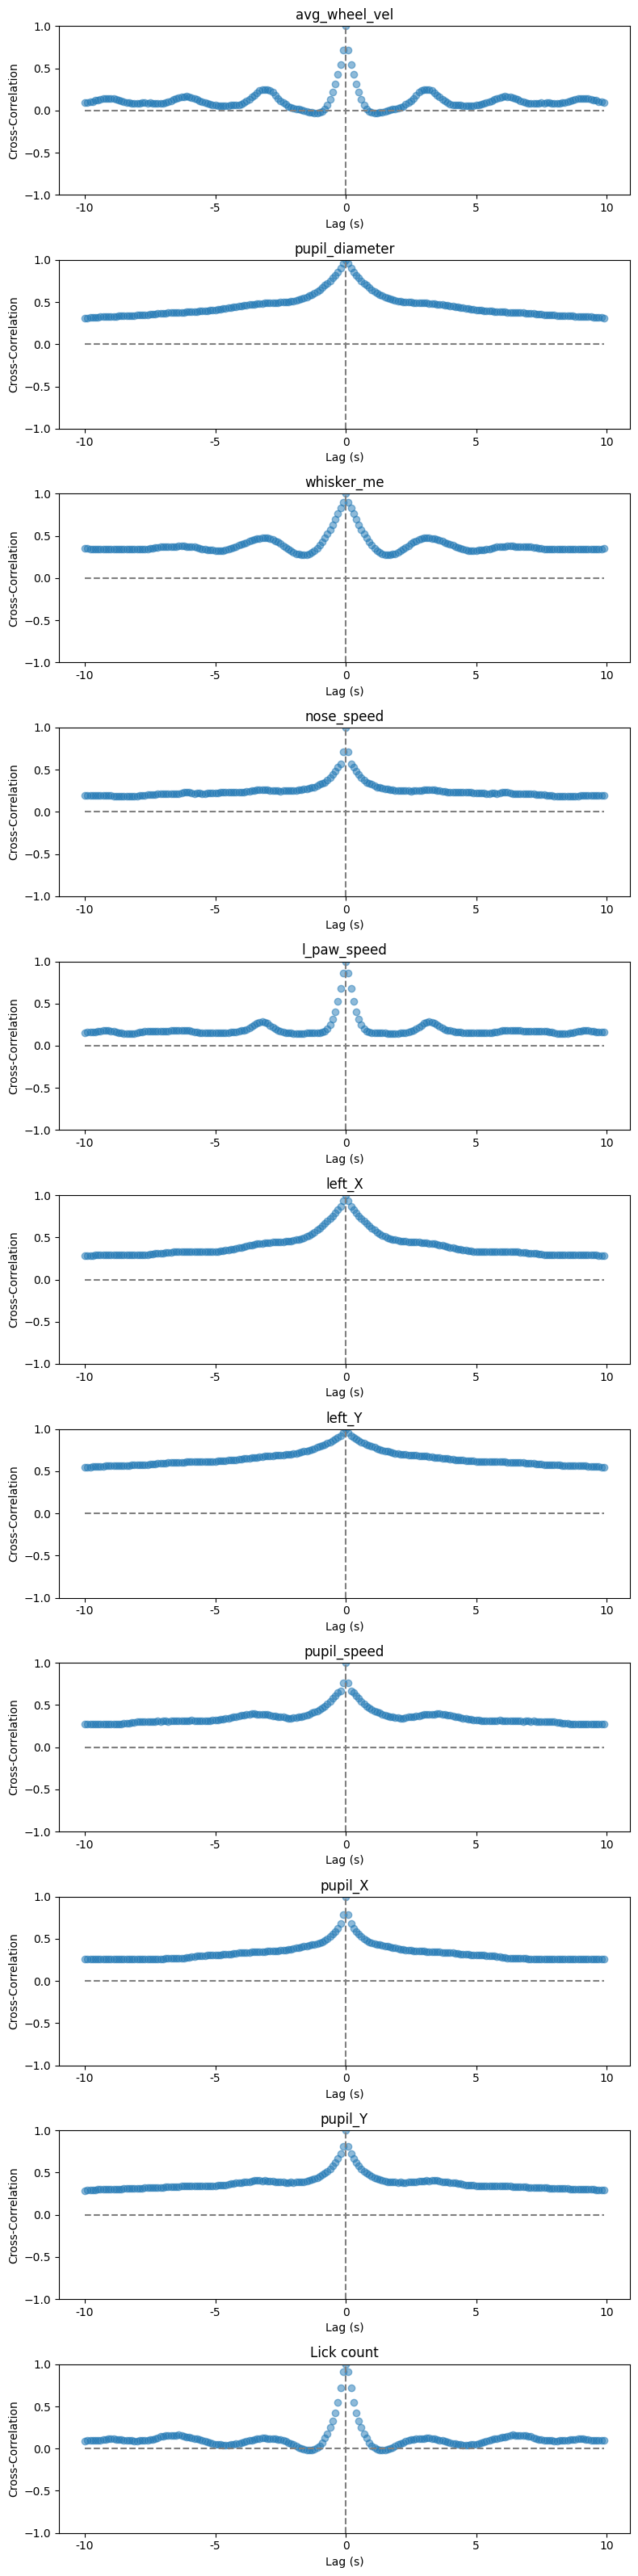

Text(0.5, 0, 'Time lag (s)')

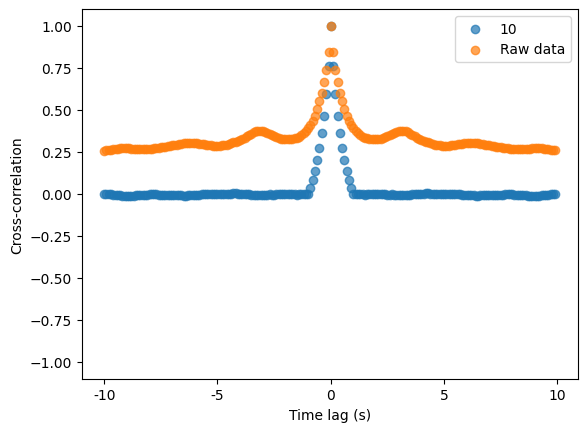

In [ ]:
features = use_data.keys()
lags_to_plot = 100

chunk_sizes = [1, 2, 5, 10]
chunk_size = [1, 5]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [use_data.iloc[i:i + chunk_size] for i in range(0, len(use_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)

    corrs = []
    corrs_shuf = []

    if c == 0:
        fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    
    for i, pc in enumerate(features):
        
        x = use_data[pc]
        x_shuf = shuffled_data[i]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        cross_correlation_shuf = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])
                
                x_chunk_shuf = np.array(x_shuf[-lag:])
                y_chunk_shuf = np.array(x_shuf[:lag])            
                
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

                x_chunk_shuf = np.array(x_shuf)
                y_chunk_shuf = np.array(x_shuf)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
                x_chunk_shuf = np.array(x_shuf[0:-lag])
                y_chunk_shuf = np.array(x_shuf[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            cross_correlation_shuf[l] = stats.pearsonr(x_chunk_shuf, y_chunk_shuf).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))
           
        # Plot the cross-correlation once 
        if c == 0:
            #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
            ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
            ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
            ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
            ax[i].set_xlabel('Lag (s)')
            ax[i].set_ylabel('Cross-Correlation')
            ax[i].set_title(pc)
            ax[i].set_ylim([-1, 1])
            ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
            plt.tight_layout()
plt.show()
    
plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size))    
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-1.1, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])
